In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle competitions download -c 'CSC4851 Homework4'
! kaggle competitions download -c csc4851-homework4 
! unzip /content/csc4851-homework4.zip

Streaming output truncated to the last 5000 lines.
  inflating: birds_400/train/VERMILION FLYCATHER/102.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/103.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/104.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/105.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/106.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/107.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/108.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/109.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/110.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/111.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/112.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/113.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/114.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/115.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/116.jpg  
  inflating: birds_400/train/VERMILION FLYCATHER/117.jpg  
  inf

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers,mixed_precision


In [4]:
train_dir='/content/birds_400/train'
val_dir='/content/birds_400/valid'
test_dir='/content/birds_400/test'

In [5]:
def plot_random_image(target_dir):
    """
    takes the directory as input and prints 5 random images from the randomly choosen class.
    """
    target_class=random.choice(os.listdir(target_dir))
    target_folder=os.path.join(target_dir,target_class)
    random_image=random.sample(os.listdir(target_folder),5)
 
    # plt.figure(figsize=(32,10))
    # for i in range(5):
        
    #     plt.subplot(1,5,i+1)
    #     img=tf.io.read_file(os.path.join(target_folder,random_image[i]))
    #     img=tf.io.decode_image(img)
    #     plt.imshow(img)
    #     plt.title(f'{target_class}\n{img.shape}')
    #     plt.axis(False)

    plt.figure(figsize=(25, 4))
    for idx in np.arange(5):
      plt.subplot(1,5,idx+1)
      img=tf.io.read_file(os.path.join(target_folder,random_image[idx]))
      img=tf.io.decode_image(img)
      plt.imshow(img)
      plt.title(f'{target_class}\n{img.shape}')

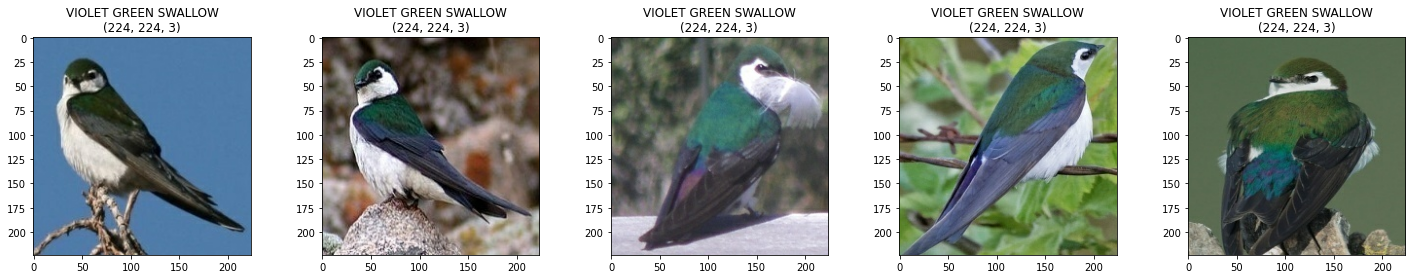

In [6]:
plot_random_image(train_dir)

In [7]:
IMAGE_SIZE=(224,224)

train_data=tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=IMAGE_SIZE
)
class_names=train_data.class_names
num_classes=len(class_names)
val_data=tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    
)
test_data=tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    shuffle=False
)

train_data_pf=train_data.prefetch(buffer_size=tf.data.AUTOTUNE)
val_data_pf=val_data.prefetch(buffer_size=tf.data.AUTOTUNE)
test_data_pf=test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 58388 files belonging to 400 classes.
Found 2000 files belonging to 400 classes.
Found 2000 files belonging to 400 classes.


In [8]:
data_augmentation=keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2,fill_mode='nearest'),
    # layers.Rescaling(scale=1.0/255)
],name='Data_Augmentation_Layer')

In [9]:
num_classes=len(train_data.class_names)

# mixed_precision.set_global_policy('mixed_float16')

inputs=layers.Input(shape=(224,224,3),name='input_layer')


base_model=keras.applications.efficientnet.EfficientNetB0(include_top=False, weights = "imagenet")
base_model.trainable=False

# x=data_augmentation(inputs)

x=base_model(inputs,training=False)
x=layers.GlobalAveragePooling2D(name='Global_Average_Pool_2D')(x)
x=layers.Dropout(0.4)(x)
outputs=layers.Dense(num_classes,activation='softmax',dtype=tf.float32,name="Output_layer")(x)

model=keras.Model(inputs,outputs,name="model")

16719872/16705208 [==============================] - 1s 0us/step


In [10]:
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Global_Average_Pool_2D (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 Output_layer (Dense)        (None, 400)               512400    
                                                                 
Total params: 4,561,971
Trainable params: 512,400
Non-trainable params: 4,049,571
_____________________________________________

In [12]:
EPOCHS=10
history_of_model=model.fit(
    train_data_pf,
    epochs=EPOCHS,
    steps_per_epoch=int (0.1*len(train_data_pf)),
    validation_data=val_data_pf,
    validation_steps=len(val_data_pf)    
)

Epoch 1/10
182/182 [==============================] - 56s 189ms/step - loss: 4.5895 - accuracy: 0.2483 - val_loss: 2.8803 - val_accuracy: 0.6205
Epoch 2/10
182/182 [==============================] - 32s 175ms/step - loss: 2.3080 - accuracy: 0.6587 - val_loss: 1.4595 - val_accuracy: 0.8420
Epoch 3/10
182/182 [==============================] - 32s 177ms/step - loss: 1.4129 - accuracy: 0.7842 - val_loss: 0.9071 - val_accuracy: 0.9005
Epoch 4/10
182/182 [==============================] - 32s 177ms/step - loss: 1.0736 - accuracy: 0.8247 - val_loss: 0.6566 - val_accuracy: 0.9220
Epoch 5/10
182/182 [==============================] - 32s 176ms/step - loss: 0.8422 - accuracy: 0.8573 - val_loss: 0.5178 - val_accuracy: 0.9350
Epoch 6/10
182/182 [==============================] - 32s 176ms/step - loss: 0.7021 - accuracy: 0.8855 - val_loss: 0.4262 - val_accuracy: 0.9365
Epoch 7/10
182/182 [==============================] - 32s 176ms/step - loss: 0.6547 - accuracy: 0.8748 - val_loss: 0.3660 - val_ac

In [13]:
model_0_result=model.evaluate(test_data_pf)
model_0_result

63/63 [==============================] - 8s 131ms/step - loss: 0.2260 - accuracy: 0.9690


[0.2259892076253891, 0.968999981880188]

In [14]:
y_prob = model.predict(test_data_pf) 
y_pred = y_prob.argmax(axis=-1)

In [15]:
y_pred[400:450]

array([ 80,  80,  80,  80,  80,  81,  81,  81,  81,  81,  82,  82,  82,
       249,  82,  83,  83,  83,  83,  83,  84,  84,  84,  84, 287,  85,
        85,  85,  85,  85,  86,  86,  86,  86,  86,  87,  87,  87,  87,
        87,  88,  88,  88,  88,  88,  89,  89,  89,  89,  89])

In [16]:
def plot_loss_curves(history):
    
    '''
      returns seperate loss curves for training and validation metrics
    '''
    train_loss=history.history['loss']
    val_loss=history.history['val_loss']

    train_accuracy=history.history['accuracy']
    val_accuracy=history.history['val_accuracy']

    epochs=range(1,len(history.history['loss'])+1)
    plt.figure(figsize=(20,7))
  # plot loss data
    plt.subplot(1,2,1)
    plt.plot(epochs,train_loss,label="training_loss")
    plt.plot(epochs,val_loss,label="validation_loss")
    plt.title("Loss curves")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
  # plt.show()

  # plot accuracy data
    plt.subplot(1,2,2)
    plt.plot(epochs,train_accuracy,label="training_acc")
    plt.plot(epochs,val_accuracy,label="validation_acc")
    plt.title("Accuracy curves")
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend()

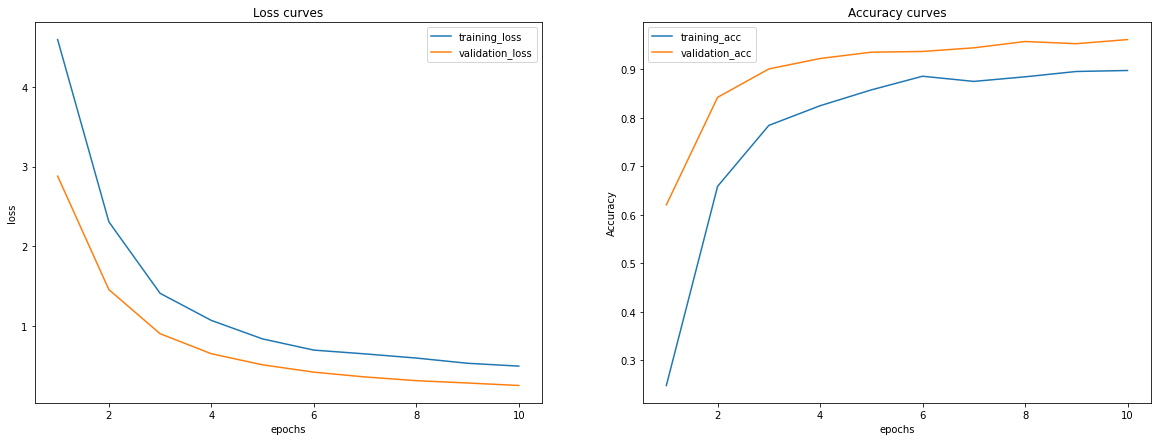

In [17]:
plot_loss_curves(history_of_model)

In [18]:
def log_loss_cal(encoded, y_prob, x,y):
    counter = 0 
    res = 0
    
    for act_row, pred_row in zip(encoded[x:y], y_prob[x:y]):
        counter += 1    
        for class_act, class_pred in zip(act_row, pred_row):
            res += - class_act * np.log(class_pred)
    return res/5

In [19]:
import pandas as pd
df = pd.read_csv('/content/birds_400/birds.csv')
rslt_df = df[df['data set'] == 'test']
rslt_df
index = rslt_df['class index']
y_actual = index.to_numpy()
y_prob = model.predict(test_data_pf) 
y_pred = y_prob.argmax(axis=-1)

In [20]:
from tensorflow.keras.utils import to_categorical
encoded = to_categorical(y_actual)

In [21]:
log_loss1 = []
ID = []
count = 0

for i in range(0,2000,5):
    x = i 
    y = i+5
    ans = log_loss_cal(encoded, y_prob, x, y)
    log_loss1.append(ans)
    ID.append(count)
    count += 1

In [22]:
sub = pd.DataFrame(ID, columns = ['id'])
sub.head()

,id
0,0
1,1
2,2
3,3
4,4


In [23]:
sub1 = pd.DataFrame(log_loss1, columns = ['birds'])
sub1.head()


,birds
0,0.659747
1,1.002279
2,0.196604
3,0.009883
4,0.137628


In [24]:
final = pd.concat([sub, sub1], axis = 1)
final.head(10)

,id,birds
0,0,0.659747
1,1,1.002279
2,2,0.196604
3,3,0.009883
4,4,0.137628
5,5,0.230622
6,6,0.129607
7,7,0.322550
8,8,0.500674
9,9,0.055560


In [ ]:
final.to_csv('sub3.csv', index = False)

Other Models 
